# Predicting Unseen Triggers

## Overview

In this notebook, we focus on identifying the trigger types that are least represented within the dataset. We develop a classification approach where we target prediction of whether a sentence contains a Trigger clause at all (i.e., Trigger Sentence vs. Nontrigger Sentence). 

For this approach, a custom Training set is created, containing balanced classes of the larged trigger categories. The Test set contains the small classes that have not been exposed to model. 

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
# pd.set_option('display.max_rows', 151)
# pd.set_option('display.max_columns', 30)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

import time
import pickle

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg', disable = 'parser')

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


## Import Data

In [2]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_16_20.csv', encoding='latin-1')
raw_df = raw_df.dropna(how='all')

In [3]:
# Review the first few rows of the data set
raw_df.head()

,ï»¿Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [4]:
raw_df.rename(columns={'ï»¿Document': 'Document'}, inplace = True)

In [5]:
# Check size of the data set
raw_df.shape

(2668, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2668, 4)

In [9]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0
5,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,Loan Default,0
6,20120828_01Y0R8_Prospectus_CM00000000205875087...,So long as no Trigger Period or Event of Defau...,Loan Default,0
7,20120828_01Y0R8_Prospectus_CM00000000205875087...,During the continuance of a Trigger Period or ...,Loan Default,0
8,20120828_01Y0R8_Prospectus_CM00000000205875087...,âTrigger Periodâ means any period that the...,DSCR Fall,0
9,20120828_01Y0R8_Prospectus_CM00000000205875087...,"During the continuance of a Trigger Period, th...",Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   509
Loan Default                  493
Debt Yield Fall               172
Loan default                   75
Tenant Failure                 74
Mezzanine Default              68
Bankruptcy                     47
Debt yield fall                34
Renovations                    26
DSCR Fall                      24
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      13
Mezzanine Outstanding          10
SFF                             9
Mezzanine default               8
Aggregate DSCR Fall             8
Aggregate debt yield fall       6
Delayed Repayment               3
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [13]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [14]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [15]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  568
Unspecified                   509
Debt Yield Fall               206
Mezzanine Default              76
Tenant Failure                 74
Bankruptcy                     47
Renovations                    26
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      19
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

In [16]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [17]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [18]:
raw_df.shape

(2668, 3)

In [19]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

36 unique documents have been included in the data set


In [20]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [21]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 36 Documents have tag counts that range from 25 to 176.


In [22]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  568
Unspecified                   509
Debt Yield Fall               206
Mezzanine Default              76
Tenant Failure                 74
Bankruptcy                     47
Renovations                    26
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      19
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

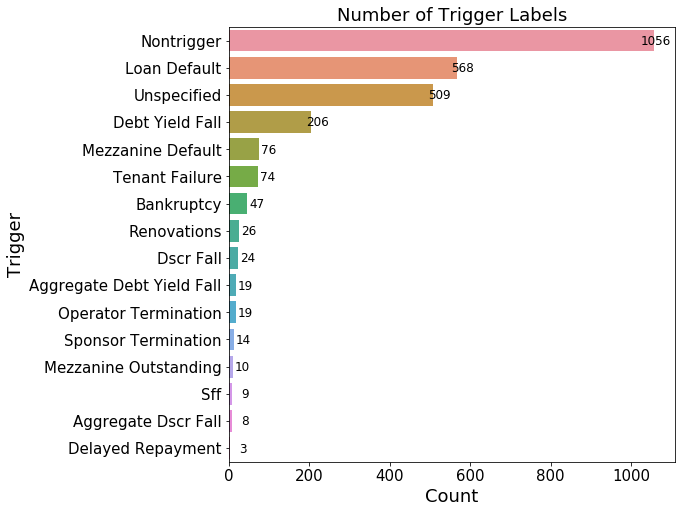

In [23]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Labels', fontsize = 18)

plt.xlabel('Count', fontsize = 18)
plt.ylabel('Trigger', fontsize = 18)
plt.tick_params(labelsize=15)

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=12,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [24]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [25]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [26]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
    
    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [27]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [28]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df.shape

(2280, 18)

## Resampling 

In [30]:
#Total sum per row: 
downsampling_set = df
downsampling_set.loc[:,'Total'] = downsampling_set.sum(axis=1)

# select only those with a single type of trigger
downsampling_set = downsampling_set[downsampling_set['Total'].isin([1,2])]
downsampling_set.head()



,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [31]:
# Check how many of each in the data set
downsampling_set.drop(['Document', 'Sentence'], axis=1).sum(axis=0)

loan_default                  468.0
aggregate_dscr_fall             2.0
dscr_fall                      13.0
unspecified                   498.0
debt_yield_fall               124.0
aggregate_debt_yield_fall      14.0
mezzanine_default              25.0
tenant_failure                 53.0
mezzanine_outstanding           6.0
operator_termination           13.0
bankruptcy                     10.0
sponsor_termination            14.0
renovations                    16.0
nontrigger                   1030.0
sff                             5.0
delayed_repayment               1.0
Total                        2292.0
dtype: float64

In [32]:
# isolate the trigger columns to sample from
n = 10
trigger_cols = downsampling_set.drop(['Document', 'Sentence'], axis=1).sum(axis=0)
trigger_cols = trigger_cols.where(lambda x: x > n).dropna()
trigger_cols = [t for t in list(trigger_cols.index) if t not in ['Total', 'nontrigger', 'unspecified']]
nontrigger_cols = ['nontrigger']

In [33]:
# randomly sample n rows from the selected trigger columns without replacement - samples is the training set
init = True

for col in trigger_cols:
    temp_col = downsampling_set[downsampling_set[col] == 1]
    sampled_col = resample(temp_col, replace = False, n_samples = n, random_state = RANDOM_STATE)
    if init:
        samples = sampled_col
        init = False
    else:
        samples = pd.concat([samples,sampled_col])
n_unspecified = samples.shape[0] # Prepare to randomaly collect nontrigger data of an equivalent size
for col in nontrigger_cols:
    temp_col = downsampling_set[downsampling_set[col] == 1]
    nontrigger_sampled_col = resample(temp_col, replace = False, n_samples = n_unspecified, random_state = RANDOM_STATE)
    samples = pd.concat([samples, nontrigger_sampled_col])


In [34]:
       
        
# remove these rows from the main data set - select index and remove by index
rmv_index = list(samples.index)
filtered = df.drop(rmv_index, axis='index') # This will become our Test Set

In [35]:

# make 'is trigger' column
samples['istrigger'] = np.where(samples['nontrigger']>0, 0, 1)
filtered['istrigger'] = np.where(filtered['nontrigger']>0, 0, 1)

In [36]:
samples.shape

(180, 20)

In [37]:
filtered.shape

(2101, 20)

Goal: Train our model on the subset of samples and predict the is_trigger column of filtered

In [38]:
# Check which trigger types were included in the training set
in_train_set = (downsampling_set.drop(['Document', 'Sentence', 'Total', 'unspecified'], axis=1).sum(axis=0) > n).to_frame()
in_train_set

,0
loan_default,True
aggregate_dscr_fall,False
dscr_fall,True
debt_yield_fall,True
aggregate_debt_yield_fall,True
mezzanine_default,True
tenant_failure,True
mezzanine_outstanding,False
operator_termination,True
bankruptcy,False


In [39]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [40]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [41]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total,sum
Document,,,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,0,63.0,126.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,0,56.0,112.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,0,25.0,50.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,0,117.0,234.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,0,62.0,124.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,0,68.0,136.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,0,84.0,168.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,0,69.0,138.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,0,64.0,128.0


In [42]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_16_20.csv')

In [43]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [44]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [45]:
df.shape

(2280, 19)

## Natural Language Processing of the sentence column

In [46]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [47]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

samples['SentenceTokens'] = samples['Sentence'].apply(tokenize)
filtered['SentenceTokens'] = filtered['Sentence'].apply(tokenize)

In [48]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

samples['SentenceLemmas'] = samples['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')
filtered['SentenceLemmas'] = filtered['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')

## Preprocessing and Preparation for Modeling

In [49]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']
short_stopwords3 = ['or', 'the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'as']

In [50]:
# Look at original stopword list
stopwords = list(STOP_WORDS)

## Train/Test Split

In [51]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [52]:
# Manually defining the Train and Test split


X_train = samples['SentenceLemmas']
y_train = samples['istrigger']
X_test = filtered['SentenceLemmas']
y_test = filtered['istrigger']
# indices = df.index

y_train = y_train.astype('int')
y_test = y_test.astype('int')

train_index = samples.index
test_index = filtered.index

In [53]:
y_train.dtypes

dtype('int64')

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [54]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'roc_auc')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 8.903


In [55]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 1.000
Test score is 0.910
Seconds elapsed for score calculation: 0.343


In [56]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.897
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 100, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': ['other', 'until', 'in', 'therefore', 'amongst', 'two', 'say', 'move', 'else', 'few', 'these', 'who', 'her', 'too', 'often', 'nobody', 'whereas', 'by', 'without', 'between', 'during', 'besides', 'nowhere', 'except', 'seem', 'cannot', 'make', 'well', 'onto', 'where', 'ten', 'herein', 'noone', 'of', 'everyone', 'nothing', 'any', 'just', 'or', 'yet', 'further', 'enough', 'behind', 'you', 'fifteen', 'beforehand', 'as', 'but', 'made', 'side', 'whereby', 'himself', 'elsewhere', 'there', 'whenever', 'across', 'have', 'those', 'give', 'some', 'yours', 'becomes', 'afterwards', 'almost', 'quite', 'so', 'per', 'first', 'eight', 'beyond', 'more', 'she', 'what', 'keep', 'everywhere', 'ourselves', 'should', 'many', 'formerly', 'against', 'everything', 'whereupon', 'throughout', 'name', 'each', 'none', 'since', 'nor', 'became', 'done', 'along', 'somew

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [57]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.447
CountVectorizer + LogisticRegression Accuracy: 1.000


In [58]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.447
CountVectorizer + LogisticRegression Accuracy: 0.910


## Model Evaluation - Logistic Regression

In [59]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [60]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.06439452863422007,
 -0.04655490420323025,
 -0.03034493710268645,
 -0.11338508840717752,
 -0.10548823279975336,
 0.000423747846304094,
 0.000423747846304094,
 0.14837326929600123,
 0.19738135848252053,
 -0.07305759811154215]

In [61]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [62]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [63]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
28,event,1.319524
22,default,1.014372
63,period,0.886996
14,commence,0.758906
64,period commence,0.757756
29,event default,0.735820
96,trigger,0.665888
27,equal,0.609142
99,yield,0.593229
21,debt yield,0.593229


In [64]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
43,management,-0.783889
47,mean,-0.575666
74,require,-0.510080
68,pursuant,-0.507222
91,tenant,-0.489661
24,describe,-0.419748
66,property,-0.417122
65,pron,-0.406568
67,provide,-0.337249
45,management agreement,-0.325029


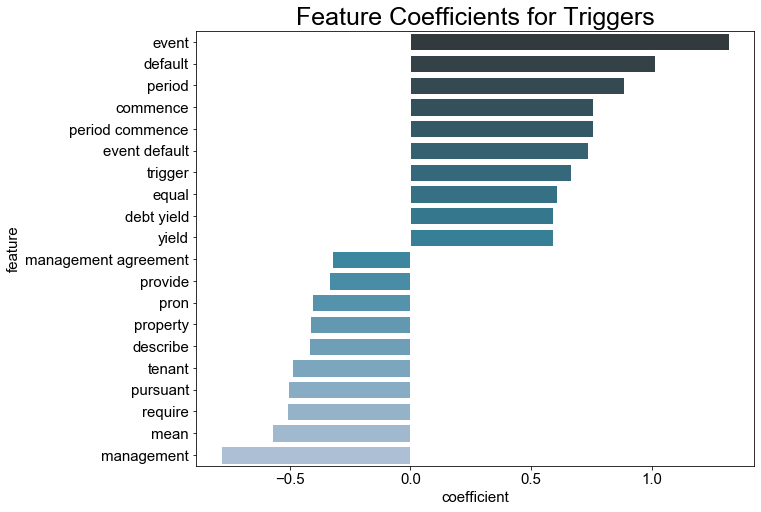

In [65]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for Triggers', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [66]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [67]:
# Checking our predictions
preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [68]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[902  38]
 [379 782]]


In [69]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [70]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,902,38
Actual Positive,379,782


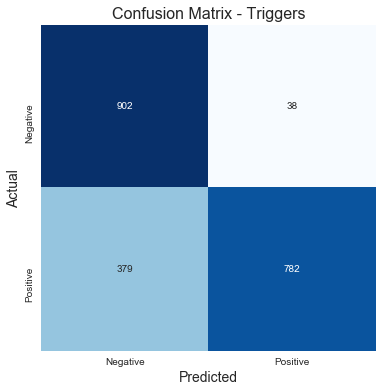

In [71]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - Triggers', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [72]:
# Setting up probabilities for the ROC curve
#pred_proba = results_cvec.predict_proba(X_test)
#preds = results_cvec.predict(X_test)



In [73]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(2101, 2)

In [74]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

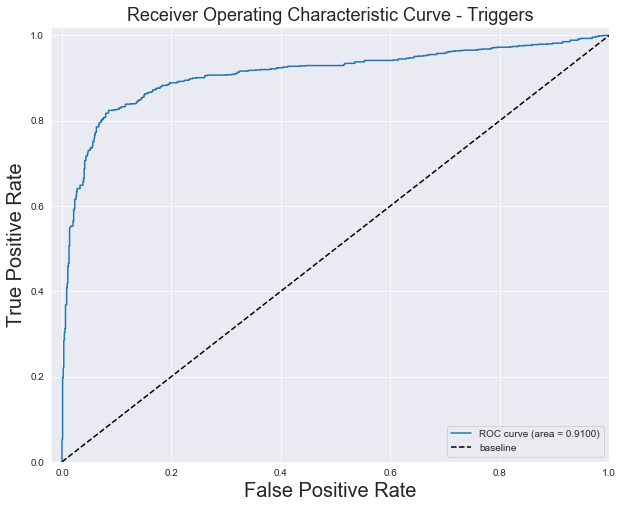

In [75]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - Triggers', fontsize=18)
plt.legend(loc="lower right");

In [76]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [77]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(test_index),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

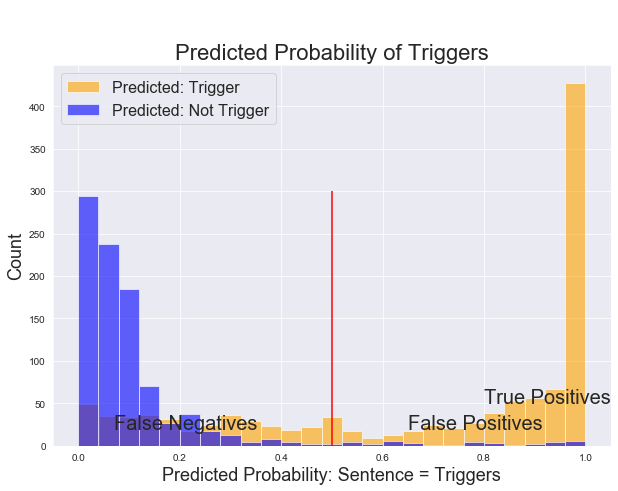

In [78]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: Trigger')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not Trigger')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of Triggers', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability: Sentence = Triggers', fontsize = 18)

plt.annotate(xy = (0.05, 500), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.65, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 50), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [79]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
0,1,1,on each business day the financial institution maintain the block account which be u s bank national association as of the origination date be require to remit all fund on deposit in the block account a if no trigger period or event of default under the mortgage loan be continue to the borrower and b during a trigger period or while an event of default under the mortgage loan be continue to the cash management account
1,1,1,the borrower have establish and be require to maintain a cash management account the cash management account at the cash management bank into which income from the property other than certain de minimis non core and sponsorship income be require to be deposit during any period that the aggregate debt service coverage ratio base on net operating income as calculate under the loan documents for the trail 12 month period as of the most recent fiscal quarter and annualiz debt service include any schedule amortization fall below 1 30x as of the end of any fiscal quarter until such debt service coverage ratio exceed 1 30x as of the end of the trail 12 month period for two consecutive fiscal quarter such period a trigger period or while an event of default under the mortgage loan be continue
2,1,1,during a trigger period or while an event of default under the mortgage loan be continue all amount available in the cash management account will be apply on each loan payment date in the follow order of priority i to the tax and insurance reserve account a 1 12th of project annual tax and b 1 12th of project annual insurance premium unless certain blanket policy be in effect ii to the lender the amount of all schedule or delinquent interest and principal on the mortgage loan and all other amount then due and payable under the loan documents with amount in respect of principal pay last iii provide there have be no enforcement action after the occurrence and during the continuance of an event of default under the mortgage loan to operating account an amount equal to the budget operating expense for the month in which such loan payment date occur as describe in description of the mortgage loan cash management iv to the capital expenditure reserve account an amount equal to the less of a 9 018 which be 0 15 per own rentable square foot per annum or b the amount that would because the total amount contain in the capital expenditure reserve account to equal 108 216 which be 12 time the monthly require amount set forth in clause a v to the ti lc reserve account an amount equal to the less of a 60 120 which be 1 00 per own rentable square foot per annum or b the amount that would because the total amount contain in the capital expenditure reserve account to equal 721 438 which be 12 time the monthly require amount set forth in clause a and vi unless an event of default under the loan documents be continue all remain amount to the borrower
3,1,1,on any business day all amount on deposit in the cash management account in excess of the amount of required reserve and all other amount due and payable on the next loan payment date will be release to the borrower unless an event of default under the mortgage loan have occur and be continue
4,1,1,available fund in each cash management account be require to be sweep into either the operating accounts or upon the commencement of a trigger period or event of default the cash management account at the end of each business day


In [80]:
misclassified = results[results['prediction'] != results['actual']]


In [81]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [82]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff', 'delayed_repayment']]

In [83]:
full_test_set = filtered.drop(['Document', 'Sentence', 'Total', 'istrigger', 'SentenceTokens', 'SentenceLemmas'], axis = 1).sum(axis = 0).to_frame()
full_test_set

,0
loan_default,524.0
aggregate_dscr_fall,7.0
dscr_fall,13.0
unspecified,498.0
debt_yield_fall,171.0
aggregate_debt_yield_fall,9.0
mezzanine_default,62.0
tenant_failure,64.0
mezzanine_outstanding,7.0
operator_termination,7.0


In [84]:
# Check how many of each in the data set
misclassified_test_set = misclassified.drop(['prediction', 'actual', 'Document', 'Sentence', 'model_input'], axis=1).sum(axis=0).to_frame()
misclassified_test_set

,0
loan_default,38.0
aggregate_dscr_fall,0.0
dscr_fall,0.0
unspecified,313.0
debt_yield_fall,12.0
aggregate_debt_yield_fall,0.0
mezzanine_default,0.0
tenant_failure,6.0
mezzanine_outstanding,2.0
operator_termination,0.0


In [85]:
misclassified_results = full_test_set.merge(misclassified_test_set, left_index = True, right_index = True)
misclassified_results.rename(columns = {'0_x': 'full_test_set', '0_y': 'num_misclassified'}, inplace = True)
misclassified_results['percent_misclassified'] = 100 * misclassified_results['num_misclassified'] / misclassified_results['full_test_set']
misclassified_results['percent_misclassified'] = misclassified_results['percent_misclassified'].round(1)
misclassified_results = misclassified_results.merge(in_train_set, left_index = True, right_index = True)
misclassified_results.rename(columns = {0: 'in_train_set'}, inplace = True)
misclassified_results['in_train_set'] = misclassified_results['in_train_set'].map({True: 'yes', False: 'no'})
misclassified_results

,full_test_set,num_misclassified,percent_misclassified,in_train_set
loan_default,524.0,38.0,7.3,yes
aggregate_dscr_fall,7.0,0.0,0.0,no
dscr_fall,13.0,0.0,0.0,yes
debt_yield_fall,171.0,12.0,7.0,yes
aggregate_debt_yield_fall,9.0,0.0,0.0,yes
mezzanine_default,62.0,0.0,0.0,yes
tenant_failure,64.0,6.0,9.4,yes
mezzanine_outstanding,7.0,2.0,28.6,no
operator_termination,7.0,0.0,0.0,yes
bankruptcy,44.0,2.0,4.5,no
